In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_tweedie_deviance, mean_absolute_error, r2_score

In [3]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

In [4]:
df = pd.read_csv("processed_screen_time_vs_mental_wellness.csv")

In [ ]:
df.info()

In [5]:
X = df.select_dtypes(include=['number']).drop('mental_wellness_index_0_100', axis=1)
X.head()

,age,screen_time_hours,work_screen_hours,leisure_screen_hours,sleep_hours,sleep_quality_1_5,stress_level_0_10,productivity_0_100,exercise_hours,social_hours
0,33,10.79,5.44,5.35,6.63,1,9,44,0.30,0.10
1,28,7.40,0.37,7.03,8.05,3,5,78,0.18,0.30
2,35,9.78,1.09,8.69,6.48,1,9,51,0.16,1.14
3,42,11.13,0.56,10.57,6.89,1,10,37,0.00,0.81
4,28,13.22,4.09,9.13,5.79,1,10,38,0.34,1.44


In [6]:
Y = df['mental_wellness_index_0_100']
Y.head()

0     9.3
1    56.2
2     3.6
3     0.0
4     0.0
Name: mental_wellness_index_0_100, dtype: float64

In [19]:
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("model", KernelRidge())
])
pipe.get_params()

{'memory': None,
 'steps': [('scale', StandardScaler()), ('model', KernelRidge())],
 'transform_input': None,
 'verbose': False,
 'scale': StandardScaler(),
 'model': KernelRidge(),
 'scale__copy': True,
 'scale__with_mean': True,
 'scale__with_std': True,
 'model__alpha': 1,
 'model__coef0': 1,
 'model__degree': 3,
 'model__gamma': None,
 'model__kernel': 'linear',
 'model__kernel_params': None}

In [20]:
mod = GridSearchCV(estimator=pipe,
                   param_grid={"model__alpha": [0.1, 1, 10, 100]},
                   cv=3)

In [26]:
mod.best_estimator_

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scale', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"alpha alpha: float or array-like of shape (n_targets,), default=1.0Regularization strength; must be a positive float. Regularizationimproves the conditioning of the problem and reduces the variance ofthe estimates. Larger values specify stronger regularization.Alpha corresponds to ``1 / (2C)`` in other linear models such as:class:`~sklearn.linear_model.LogisticRegression` or:class:`~sklearn.svm.LinearSVC`. If an array is passed, penalties areassumed to be specific to the targets. Hence they must correspond innumber. See :ref:`ridge_regression` for formula.",1
,"kernel kernel: str or callable, default=""linear""Kernel mapping used internally. This parameter is directly passed to:class:`~sklearn.metrics.pairwise.pairwise_kernels`.If `kernel` is a string, it must be one of the metricsin `pairwise.PAIRWISE_KERNEL_FUNCTIONS` or ""precomputed"".If `kernel` is ""precomputed"", X is assumed to be a kernel matrix.Alternatively, if `kernel` is a callable function, it is called oneach pair of instances (rows) and the resulting value recorded. Thecallable should take two rows from X as input and return thecorresponding kernel value as a single number. This means thatcallables from :mod:`sklearn.metrics.pairwise` are not allowed, asthey operate on matrices, not single samples. Use the stringidentifying the kernel instead.",'linear'
,"gamma gamma: float, default=NoneGamma parameter for the RBF, laplacian, polynomial, exponential chi2and sigmoid kernels. Interpretation of the default value is left tothe k

## Selecting modeling technique

In [ ]:
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("model", KernelRidge())  # placeholder; will be overridden by grid
])

param_grid = [
    {
        "model": [KernelRidge()],
    },
    {
        "model": [SVR()],
    }
]

# Multiple scoring metrics
scoring = {
    'neg_mse': 'neg_mean_squared_error',
    'neg_mae': 'neg_mean_absolute_error',
    'r2': 'r2_score'
}

mod = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=3,
    scoring=scoring,  # pass dict of scoring methods
    refit='neg_mae',  # which metric to use for best_estimator_; change as needed
    n_jobs=-1
)
mod.fit(X_train, Y_train)

# View all metrics
results_df = pd.DataFrame(mod.cv_results_).sort_values("rank_test_neg_mae")
print(results_df[['param_model', 'mean_test_neg_mse', 'mean_test_neg_mae', 'mean_test_r2', 'rank_test_neg_mae']])


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,0.012625,0.003550,0.012072,0.000986,SVR(),{'model': SVR()},-184.215399,-192.058241,-218.111098,-198.128246,14.488233,1
0,0.013845,0.000257,0.004772,0.002171,KernelRidge(),{'model': KernelRidge()},-415.925124,-397.308790,-458.097552,-423.777155,25.430417,2


## Kernel Ridge

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

mod.fit(X_train, Y_train)
best_model = mod.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

print("Best parameters:", mod.best_params_)
print("Best CV score:", mod.best_score_)

Best parameters: {'model__alpha': 1}
Best CV score: -0.015426037123170958


In [23]:
# Compare predictions vs actual values (table view)
comparison = pd.DataFrame({
    'Actual': Y_test.values,
    'Predicted': y_pred,
    'Difference': Y_test.values - y_pred,
    'Abs_Error': abs(Y_test.values - y_pred)
})

print("Sample comparisons:")
print(comparison.head(20))
print(f"\nMean Absolute Error: {comparison['Abs_Error'].mean():.4f}")
print(f"Max Error: {comparison['Abs_Error'].max():.4f}")

Sample comparisons:
    Actual  Predicted  Difference  Abs_Error
0      0.0 -21.656114   21.656114  21.656114
1     12.8 -18.792646   31.592646  31.592646
2      2.4  -7.799792   10.199792  10.199792
3      3.3 -13.688123   16.988123  16.988123
4     14.4  -2.934532   17.334532  17.334532
5     72.6  44.770614   27.829386  27.829386
6     26.4   6.526170   19.873830  19.873830
7     80.9  50.750720   30.149280  30.149280
8     28.3   4.144609   24.155391  24.155391
9     52.1  31.988940   20.111060  20.111060
10    10.7  -9.709049   20.409049  20.409049
11    57.1  34.480801   22.619199  22.619199
12    39.1  27.824392   11.275608  11.275608
13    43.0  21.069288   21.930712  21.930712
14     6.5  -1.712958    8.212958   8.212958
15    62.2  44.640894   17.559106  17.559106
16     3.7 -11.413061   15.113061  15.113061
17    25.1   6.245778   18.854222  18.854222
18    20.1  11.732426    8.367574   8.367574
19    16.7   0.082179   16.617821  16.617821

Mean Absolute Error: 19.8519
Max E

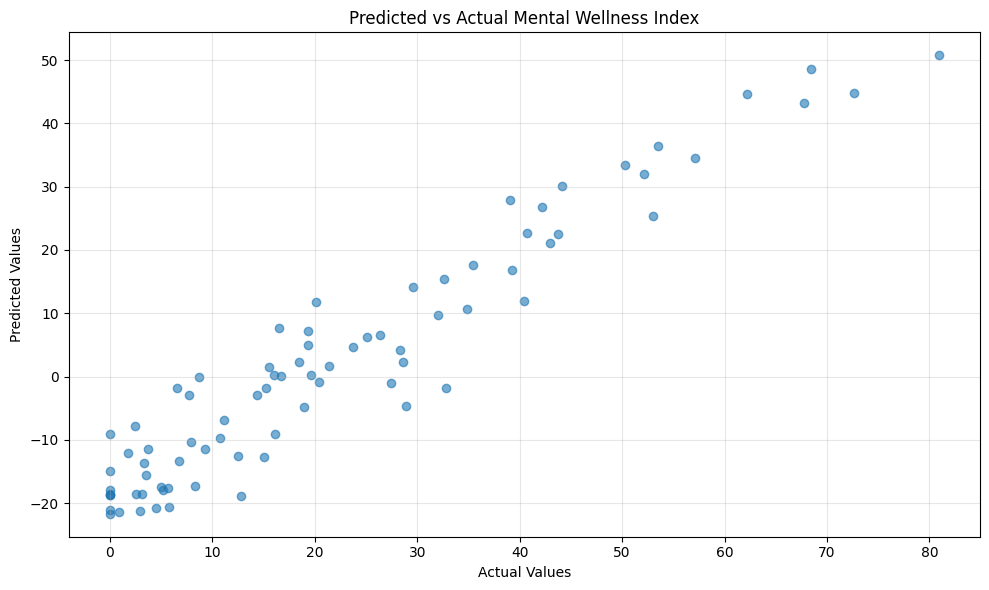

R² Score: -0.0797
RMSE: 427.0390
MAE: 19.8519


In [25]:
# Visual comparison: Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, y_pred, alpha=0.6)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Mental Wellness Index')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate metrics
print(f"R² Score: {r2_score(Y_test, y_pred):.4f}")
print(f"RMSE: {mean_tweedie_deviance(Y_test, y_pred, power=0):.4f}")
print(f"MAE: {mean_absolute_error(Y_test, y_pred):.4f}")

## Support Vector Regression

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

mod.fit(X_train, Y_train)
best_model = mod.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

print("Best parameters:", mod.best_params_)
print("Best CV score:", mod.best_score_)

Best parameters: {'model__C': 10, 'model__kernel': 'linear'}
Best CV score: 0.9299831437465821


In [12]:
# Compare predictions vs actual values (table view)
comparison = pd.DataFrame({
    'Actual': Y_test.values,
    'Predicted': y_pred,
    'Difference': Y_test.values - y_pred,
    'Abs_Error': abs(Y_test.values - y_pred)
})

print("Sample comparisons:")
print(comparison.head(20))
print(f"\nMean Absolute Error: {comparison['Abs_Error'].mean():.4f}")
print(f"Max Error: {comparison['Abs_Error'].max():.4f}")

Sample comparisons:
    Actual  Predicted  Difference  Abs_Error
0      0.0  -0.950550    0.950550   0.950550
1     12.8   0.505537   12.294463  12.294463
2      2.4  11.293733   -8.893733   8.893733
3      3.3   6.546507   -3.246507   3.246507
4     14.4  15.789266   -1.389266   1.389266
5     72.6  64.351637    8.248363   8.248363
6     26.4  26.062939    0.337061   0.337061
7     80.9  70.480988   10.419012  10.419012
8     28.3  24.056964    4.243036   4.243036
9     52.1  52.158106   -0.058106   0.058106
10    10.7  10.079192    0.620808   0.620808
11    57.1  54.514369    2.585631   2.585631
12    39.1  47.200520   -8.100520   8.100520
13    43.0  40.574719    2.425281   2.425281
14     6.5  17.490558  -10.990558  10.990558
15    62.2  65.497313   -3.297313   3.297313
16     3.7   9.386146   -5.686146   5.686146
17    25.1  26.353744   -1.253744   1.253744
18    20.1  31.305784  -11.205784  11.205784
19    16.7  20.373939   -3.673939   3.673939

Mean Absolute Error: 4.4510
Max Er

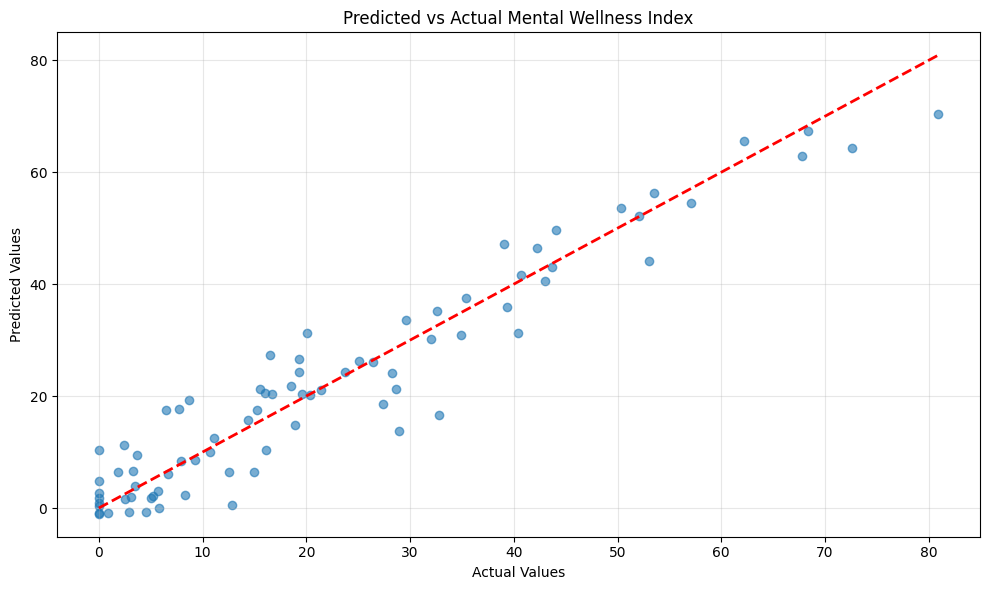

R² Score: 0.9146
RMSE: 33.7808
MAE: 4.4510


In [16]:
# Visual comparison: Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, y_pred, alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Mental Wellness Index')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate metrics
print(f"R² Score: {r2_score(Y_test, y_pred):.4f}")
print(f"RMSE: {mean_tweedie_deviance(Y_test, y_pred, power=0):.4f}")
print(f"MAE: {mean_absolute_error(Y_test, y_pred):.4f}")

In [40]:
# Predict for a custom person profile
# Fill in values for each numeric feature; order follows X.columns
custom_person = {
    "age": 40,
    "screen_time_hours": 5.0,
    "work_screen_hours": 3.0,
    "leisure_screen_hours": 2.0,
    "sleep_hours": 7.5,
    "sleep_quality_1_5": 3,
    "stress_level_0_10": 1,
    "productivity_0_100": 60,
    "exercise_hours": 2.0,
    "social_hours": 2.0,
}

# Ensure column order matches the training data
custom_df = pd.DataFrame([custom_person])[X.columns]

# Use the best_model found by GridSearchCV
predicted_wellness = best_model.predict(custom_df)[0]
print(f"Predicted mental wellness index: {predicted_wellness:.2f}")

Predicted mental wellness index: 64.68


# Clustering Analysis

In [50]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

In [51]:
# Prepare data for clustering - use the same feature set
X_clustering = X.copy()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

print(f"Data shape: {X_scaled.shape}")
print(f"Features: {list(X_clustering.columns)}")

Data shape: (400, 10)
Features: ['age', 'screen_time_hours', 'work_screen_hours', 'leisure_screen_hours', 'sleep_hours', 'sleep_quality_1_5', 'stress_level_0_10', 'productivity_0_100', 'exercise_hours', 'social_hours']


## Finding Optimal Number of Clusters

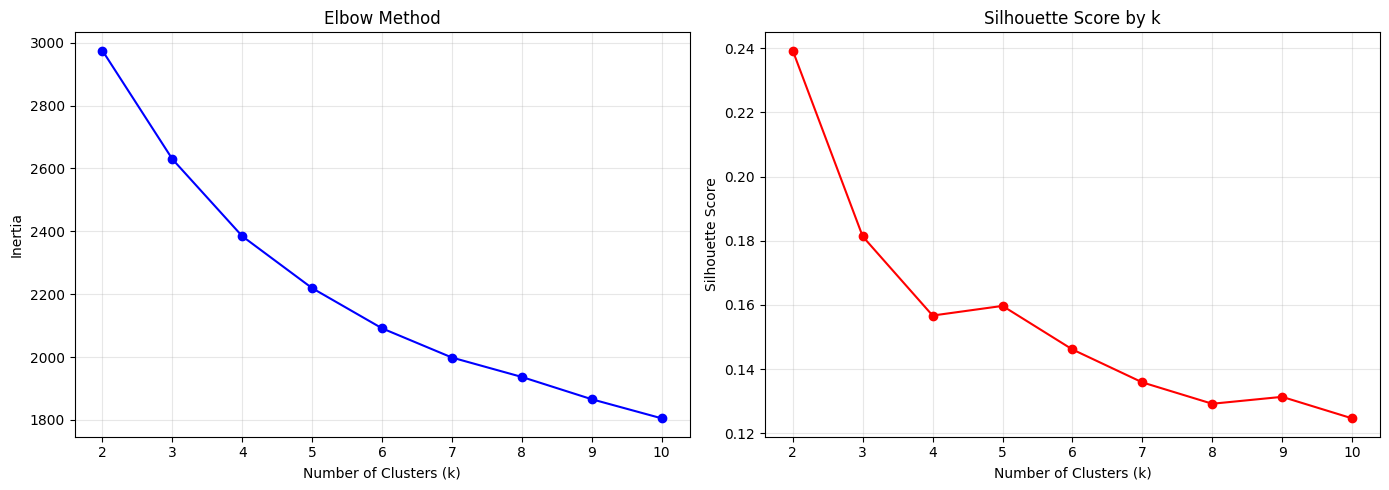

Silhouette scores by k:
k=2: 0.2392
k=3: 0.1813
k=4: 0.1567
k=5: 0.1597
k=6: 0.1461
k=7: 0.1359
k=8: 0.1292
k=9: 0.1314
k=10: 0.1247


In [52]:
# Elbow method to find optimal k
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow curve and Silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax1.grid(True, alpha=0.3)

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score by k')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Silhouette scores by k:")
for k, score in zip(k_range, silhouette_scores):
    print(f"k={k}: {score:.4f}")

## K-Means Clustering

In [58]:
# Apply K-Means with optimal k (let's start with k=3)
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df['cluster'] = clusters

print(f"Cluster distribution:")
print(df['cluster'].value_counts().sort_index())
print(f"\nSilhouette Score: {silhouette_score(X_scaled, clusters):.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_scaled, clusters):.4f}")

Cluster distribution:
cluster
0    262
1    138
Name: count, dtype: int64

Silhouette Score: 0.2392
Davies-Bouldin Index: 1.5791


In [59]:
# Analyze cluster characteristics
cluster_summary = df.groupby('cluster').agg({
    'age': 'mean',
    'screen_time_hours': 'mean',
    'work_screen_hours': 'mean',
    'leisure_screen_hours': 'mean',
    'sleep_hours': 'mean',
    'sleep_quality_1_5': 'mean',
    'stress_level_0_10': 'mean',
    'productivity_0_100': 'mean',
    'exercise_hours': 'mean',
    'social_hours': 'mean',
    'mental_wellness_index_0_100': 'mean'
}).round(2)

print("Cluster Characteristics:")
print(cluster_summary)

Cluster Characteristics:
           age  screen_time_hours  work_screen_hours  leisure_screen_hours  \
cluster                                                                      
0        29.79              10.14               2.56                  7.58   
1        29.76               6.90               1.47                  5.43   

         sleep_hours  sleep_quality_1_5  stress_level_0_10  \
cluster                                                      
0               6.66               1.11               9.09   
1               7.69               1.94               5.49   

         productivity_0_100  exercise_hours  social_hours  \
cluster                                                     
0                     45.70            0.24          1.09   
1                     69.39            0.31          1.20   

         mental_wellness_index_0_100  
cluster                               
0                               8.77  
1                              42.27  


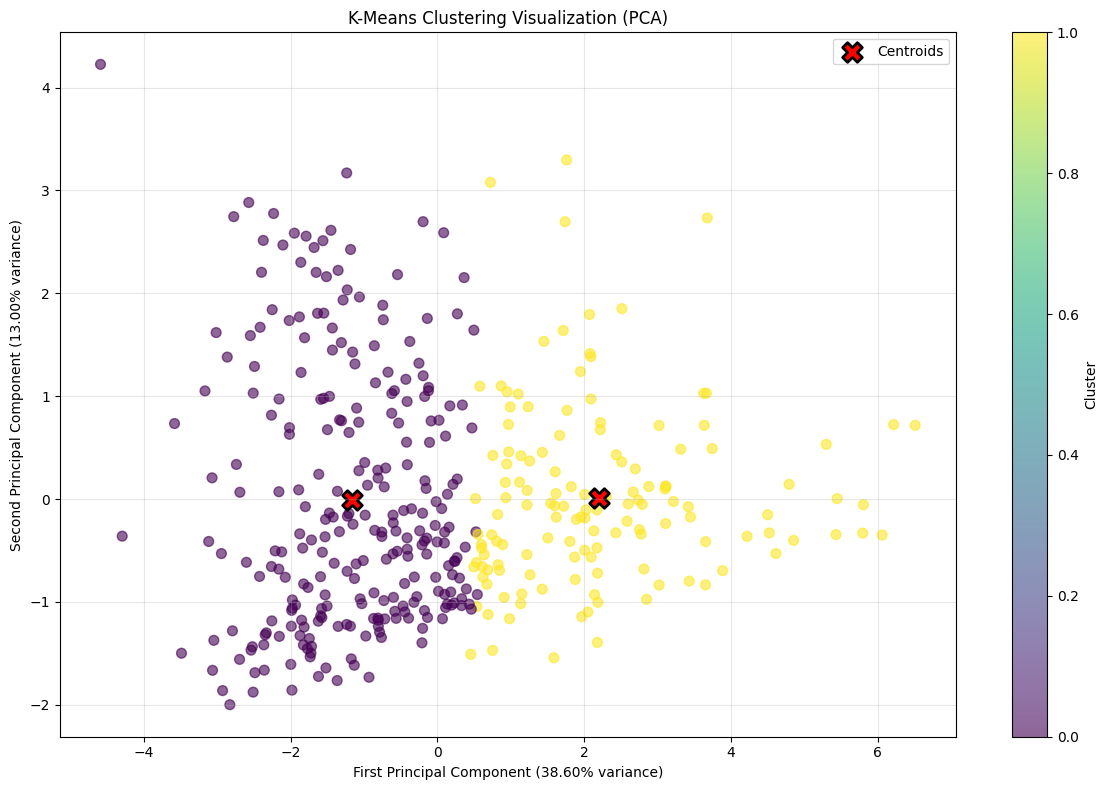

Total variance explained by 2 components: 51.60%


In [60]:
# Visualize clusters using PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6, s=50)
plt.scatter(pca.transform(kmeans.cluster_centers_)[:, 0], 
            pca.transform(kmeans.cluster_centers_)[:, 1], 
            c='red', marker='X', s=200, edgecolors='black', linewidths=2, label='Centroids')
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('K-Means Clustering Visualization (PCA)')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total variance explained by 2 components: {sum(pca.explained_variance_ratio_):.2%}")

C:\Users\joaod\AppData\Local\Temp\ipykernel_17536\594565544.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


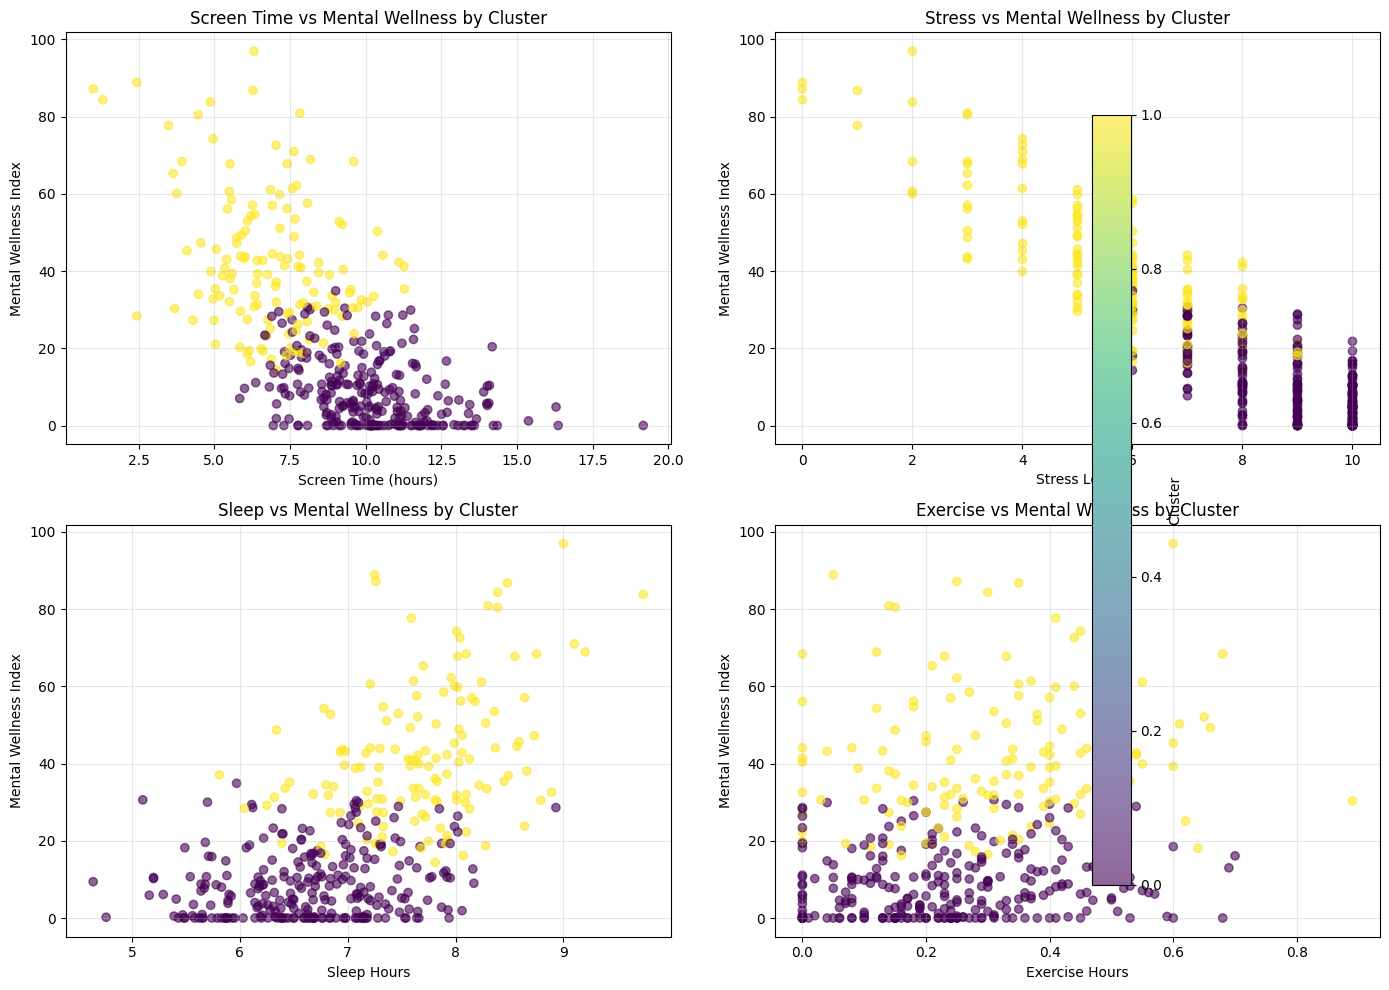

In [61]:
# Visualize key features by cluster
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Screen time vs Mental wellness by cluster
axes[0, 0].scatter(df['screen_time_hours'], df['mental_wellness_index_0_100'], 
                   c=df['cluster'], cmap='viridis', alpha=0.6)
axes[0, 0].set_xlabel('Screen Time (hours)')
axes[0, 0].set_ylabel('Mental Wellness Index')
axes[0, 0].set_title('Screen Time vs Mental Wellness by Cluster')
axes[0, 0].grid(True, alpha=0.3)

# Stress vs Mental wellness by cluster
axes[0, 1].scatter(df['stress_level_0_10'], df['mental_wellness_index_0_100'], 
                   c=df['cluster'], cmap='viridis', alpha=0.6)
axes[0, 1].set_xlabel('Stress Level')
axes[0, 1].set_ylabel('Mental Wellness Index')
axes[0, 1].set_title('Stress vs Mental Wellness by Cluster')
axes[0, 1].grid(True, alpha=0.3)

# Sleep vs Mental wellness by cluster
axes[1, 0].scatter(df['sleep_hours'], df['mental_wellness_index_0_100'], 
                   c=df['cluster'], cmap='viridis', alpha=0.6)
axes[1, 0].set_xlabel('Sleep Hours')
axes[1, 0].set_ylabel('Mental Wellness Index')
axes[1, 0].set_title('Sleep vs Mental Wellness by Cluster')
axes[1, 0].grid(True, alpha=0.3)

# Exercise vs Mental wellness by cluster
scatter = axes[1, 1].scatter(df['exercise_hours'], df['mental_wellness_index_0_100'], 
                             c=df['cluster'], cmap='viridis', alpha=0.6)
axes[1, 1].set_xlabel('Exercise Hours')
axes[1, 1].set_ylabel('Mental Wellness Index')
axes[1, 1].set_title('Exercise vs Mental Wellness by Cluster')
axes[1, 1].grid(True, alpha=0.3)

plt.colorbar(scatter, ax=axes, label='Cluster')
plt.tight_layout()
plt.show()

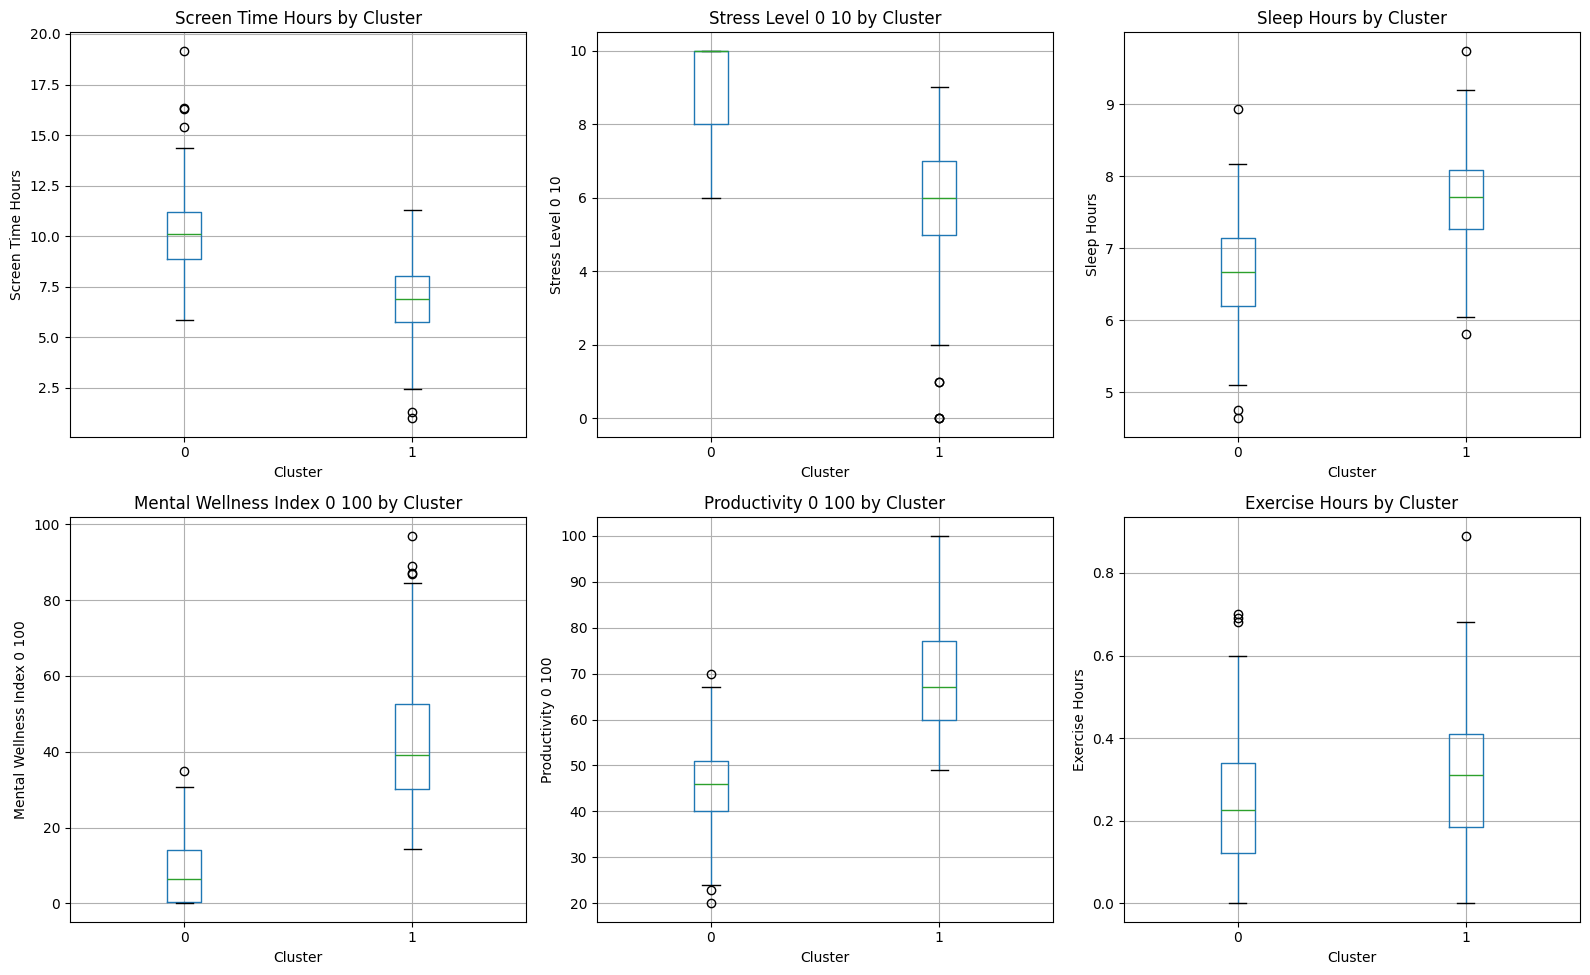

In [62]:
# Box plots for key metrics by cluster
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

metrics = ['screen_time_hours', 'stress_level_0_10', 'sleep_hours', 
           'mental_wellness_index_0_100', 'productivity_0_100', 'exercise_hours']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    df.boxplot(column=metric, by='cluster', ax=ax)
    ax.set_title(f'{metric.replace("_", " ").title()} by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(metric.replace('_', ' ').title())
    
plt.suptitle('')  # Remove the automatic title
plt.tight_layout()
plt.show()